In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW  # torch.optim에서 import
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os
import re
from datetime import datetime

In [28]:
class KoreanConversationPreprocessor:
    """
    한국어 위협 대화 데이터 전처리 클래스
    """
    def __init__(self, model_name="beomi/kcbert-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.label_encoder = LabelEncoder()

    def load_data(self, csv_path):
        """CSV 파일 로드"""
        df = pd.read_csv(csv_path)
        print(f"데이터 로드 완료: {len(df)}개 샘플")
        print(f"클래스 분포:\n{df['class'].value_counts()}")
        return df

    def clean_korean_text(self, text):
        """한국어 텍스트 정제"""
        if pd.isna(text) or text == "":
            return ""

        text = str(text)

        # 1. 특수 문자 처리 (인코딩 오류 문자 제거)
        text = re.sub(r'[羔�]', '', text)

        # 2. 과도한 반복 문자 정규화 (3개 이상 → 2개)
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)

        # 3. 과도한 문장부호 정규화
        text = re.sub(r'\?{2,}', '??', text)  # 물음표
        text = re.sub(r'!{2,}', '!!', text)   # 느낌표
        text = re.sub(r'\.{2,}', '..', text)  # 마침표

        # 4. 불필요한 공백 정리
        text = re.sub(r'\s+', ' ', text)  # 여러 공백을 하나로
        text = text.strip()

        # 5. 개행 문자 정규화 (발화 구분을 위해 유지)
        text = re.sub(r'\n\s*\n', '\n', text)  # 연속 개행 제거
        text = re.sub(r'\n\s+', '\n', text)    # 개행 후 공백 제거
        text = re.sub(r'\s+\n', '\n', text)    # 개행 전 공백 제거

        return text

    def extract_utterances(self, conversation):
        """대화에서 개별 발화 추출"""
        if not conversation:
            return []

        # 개행 문자로 발화 분리
        utterances = conversation.split('\n')

        # 빈 발화 제거 및 정제
        cleaned_utterances = []
        for utterance in utterances:
            utterance = utterance.strip()
            if utterance:  # 빈 문자열이 아닌 경우만
                cleaned_utterances.append(utterance)

        return cleaned_utterances

    def prepare_for_bert(self, conversation, max_length=512):
        """BERT 모델용 데이터 준비"""
        # 대화를 하나의 텍스트로 변환
        cleaned_conversation = self.clean_korean_text(conversation)

        # [SEP] 토큰으로 발화 구분 (선택사항)
        utterances = self.extract_utterances(cleaned_conversation)
        if len(utterances) > 1:
            bert_input = " [SEP] ".join(utterances)
        else:
            bert_input = cleaned_conversation

        # 토크나이징
        encoding = self.tokenizer(
            bert_input,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'original_text': conversation,
            'cleaned_text': cleaned_conversation,
            'bert_input': bert_input
        }

    def preprocess_dataset(self, df, max_length=512):
        """전체 데이터셋 전처리"""
        print("데이터셋 전처리 시작...")

        # 1. 텍스트 정제
        df['cleaned_conversation'] = df['conversation'].apply(self.clean_korean_text)

        # 2. 빈 데이터 제거
        df = df[df['cleaned_conversation'].str.len() > 0].reset_index(drop=True)
        print(f"빈 데이터 제거 후: {len(df)}개 샘플")

        # 3. 라벨 인코딩
        df['label_encoded'] = self.label_encoder.fit_transform(df['class'])
        print(f"라벨 매핑: {dict(zip(self.label_encoder.classes_, range(len(self.label_encoder.classes_))))}")

        # 4. BERT 입력 준비
        bert_inputs = []
        for idx, conversation in enumerate(df['cleaned_conversation']):
            if idx % 1000 == 0:
                print(f"BERT 입력 준비 중... {idx}/{len(df)}")

            bert_input = self.prepare_for_bert(conversation, max_length)
            bert_inputs.append(bert_input)

        # BERT 입력들을 별도로 저장
        input_ids = torch.stack([item['input_ids'] for item in bert_inputs])
        attention_masks = torch.stack([item['attention_mask'] for item in bert_inputs])

        print("전처리 완료!")

        return {
            'dataframe': df,
            'input_ids': input_ids,
            'attention_masks': attention_masks,
            'labels': torch.tensor(df['label_encoded'].values),
            'label_encoder': self.label_encoder
        }

# Dataset 클래스
class ConversationDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [29]:
class KcBERTTrainer:
    """
    KcBERT 위협 대화 분류 모델 훈련 클래스
    """

    def __init__(self, num_classes, model_name="beomi/kcbert-base", device=None):
        self.model_name = model_name
        self.num_classes = num_classes
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print(f"사용 장치: {self.device}")
        print(f"모델: {model_name}")
        print(f"클래스 수: {num_classes}")

        # 모델과 토크나이저 로드
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_classes
        )
        self.model.to(self.device)

        # 훈련 기록
        self.train_losses = []
        self.train_accuracies = []

    def setup_optimizer_and_scheduler(self, dataloader, epochs, learning_rate=2e-5, warmup_ratio=0.1):
        """
        옵티마이저와 스케줄러 설정
        """
        # 총 스텝 수 계산
        total_steps = len(dataloader) * epochs
        warmup_steps = int(total_steps * warmup_ratio)

        # 옵티마이저 설정 (torch.optim.AdamW 사용)
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=learning_rate,
            eps=1e-8,
            weight_decay=0.01
        )

        # 스케줄러 설정
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        print(f"총 훈련 스텝: {total_steps}")
        print(f"워밍업 스텝: {warmup_steps}")
        print(f"학습률: {learning_rate}")

    def train_epoch(self, dataloader):
        """
        한 에포크 훈련
        """
        self.model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        progress_bar = tqdm(dataloader, desc="훈련 중")

        for batch_idx, batch in enumerate(progress_bar):
            # 배치 데이터를 디바이스로 이동
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            # 그래디언트 초기화
            self.optimizer.zero_grad()

            # 순전파
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            # 역전파
            loss.backward()

            # 그래디언트 클리핑 (안정적 훈련을 위해)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # 옵티마이저 스텝
            self.optimizer.step()
            self.scheduler.step()

            # 정확도 계산
            predictions = torch.argmax(logits, dim=-1)
            correct = (predictions == labels).sum().item()

            # 통계 업데이트
            total_loss += loss.item()
            total_correct += correct
            total_samples += labels.size(0)

            # 진행바 업데이트
            current_acc = correct / labels.size(0)
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.4f}',
                'LR': f'{self.scheduler.get_last_lr()[0]:.2e}'
            })

        # 에포크 평균값 계산
        avg_loss = total_loss / len(dataloader)
        avg_accuracy = total_correct / total_samples

        return avg_loss, avg_accuracy

    def evaluate(self, dataloader, label_encoder=None):
        """
        모델 평가
        """
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        print("모델 평가 중...")

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="평가 중"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                logits = outputs.logits

                predictions = torch.argmax(logits, dim=-1)

                total_loss += loss.item()
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # 평가 지표 계산
        avg_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(all_labels, all_predictions)

        # 분류 리포트
        if label_encoder:
            target_names = label_encoder.classes_
        else:
            target_names = [f'Class_{i}' for i in range(self.num_classes)]

        report = classification_report(
            all_labels,
            all_predictions,
            target_names=target_names,
            output_dict=True
        )

        return avg_loss, accuracy, report, all_predictions, all_labels

    def train(self, dataloader, epochs=3, learning_rate=2e-5, save_path="best_model"):
        """
        전체 훈련 프로세스
        """
        print(f"\n{'='*50}")
        print(f"KcBERT 위협 대화 분류 모델 훈련 시작")
        print(f"{'='*50}")

        # 옵티마이저와 스케줄러 설정
        self.setup_optimizer_and_scheduler(dataloader, epochs, learning_rate)

        # 최고 성능 기록용
        best_accuracy = 0
        best_epoch = 0

        # 훈련 시작 시간
        start_time = time.time()

        for epoch in range(epochs):
            print(f"\n에포크 {epoch + 1}/{epochs}")
            print("-" * 30)

            # 훈련
            train_loss, train_accuracy = self.train_epoch(dataloader)

            # 기록 저장
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)

            print(f"훈련 손실: {train_loss:.4f}")
            print(f"훈련 정확도: {train_accuracy:.4f}")

            # 최고 성능 모델 저장
            if train_accuracy > best_accuracy:
                best_accuracy = train_accuracy
                best_epoch = epoch
                self.save_model(save_path)
                print(f"새로운 최고 성능! 모델 저장됨 (정확도: {best_accuracy:.4f})")

        # 훈련 완료
        total_time = time.time() - start_time
        print(f"\n{'='*50}")
        print(f"훈련 완료!")
        print(f"총 소요 시간: {total_time/60:.2f}분")
        print(f"최고 정확도: {best_accuracy:.4f} (에포크 {best_epoch + 1})")
        print(f"{'='*50}")

        return best_accuracy

    def predict(self, text, label_encoder=None):
        """
        단일 텍스트 예측
        """
        self.model.eval()

        # 텍스트 토크나이징
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        )

        inputs = {key: value.to(self.device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=-1).item()
            confidence = probabilities[0][predicted_class].item()

        # 클래스명 변환
        if label_encoder:
            class_name = label_encoder.inverse_transform([predicted_class])[0]
        else:
            class_name = f"Class_{predicted_class}"

        return {
            'predicted_class': predicted_class,
            'class_name': class_name,
            'confidence': confidence,
            'probabilities': probabilities[0].cpu().numpy()
        }

    def save_model(self, save_path):
        """
        모델 저장
        """
        os.makedirs(save_path, exist_ok=True)

        # 모델과 토크나이저 저장
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

        # 훈련 설정 저장
        config = {
            'model_name': self.model_name,
            'num_classes': self.num_classes,
            'train_losses': self.train_losses,
            'train_accuracies': self.train_accuracies
        }

        torch.save(config, os.path.join(save_path, 'training_config.pt'))

    def load_model(self, load_path):
        """
        저장된 모델 로드
        """
        self.model = AutoModelForSequenceClassification.from_pretrained(load_path)
        self.tokenizer = AutoTokenizer.from_pretrained(load_path)
        self.model.to(self.device)

        # 훈련 설정 로드
        config_path = os.path.join(load_path, 'training_config.pt')
        if os.path.exists(config_path):
            config = torch.load(config_path)
            self.train_losses = config.get('train_losses', [])
            self.train_accuracies = config.get('train_accuracies', [])

        print(f"모델이 {load_path}에서 로드되었습니다.")

    def plot_training_history(self):
        """
        훈련 기록 시각화
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # 손실 그래프
        ax1.plot(self.train_losses, 'b-', label='훈련 손실')
        ax1.set_title('훈련 손실')
        ax1.set_xlabel('에포크')
        ax1.set_ylabel('손실')
        ax1.legend()
        ax1.grid(True)

        # 정확도 그래프
        ax2.plot(self.train_accuracies, 'r-', label='훈련 정확도')
        ax2.set_title('훈련 정확도')
        ax2.set_xlabel('에포크')
        ax2.set_ylabel('정확도')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

In [30]:
def plot_confusion_matrix(y_true, y_pred, label_encoder, save_path='confusion_matrix.png'):
    """
    혼동 행렬 시각화
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title('혼동 행렬')
    plt.xlabel('예측값')
    plt.ylabel('실제값')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
def main_training():
    """
    메인 훈련 실행 함수
    """
    print("데이터 전처리 시작...")
    preprocessor = KoreanConversationPreprocessor()
    df = preprocessor.load_data('train.csv')
    processed_data = preprocessor.preprocess_dataset(df, max_length=256)

    # Dataset과 DataLoader 생성
    dataset = ConversationDataset(
        processed_data['input_ids'],
        processed_data['attention_masks'],
        processed_data['labels']
    )

    dataloader = DataLoader(
        dataset,
        batch_size=16,  # GPU 메모리에 따라 조정
        shuffle=True,
        num_workers=0  # Windows에서는 0으로 설정
    )

    # 훈련기 초기화
    num_classes = len(processed_data['label_encoder'].classes_)
    trainer = KcBERTTrainer(num_classes=num_classes)

    # 훈련 실행
    print(f"\n데이터 준비 완료!")
    print(f"- 총 샘플 수: {len(dataset)}")
    print(f"- 배치 크기: {dataloader.batch_size}")
    print(f"- 총 배치 수: {len(dataloader)}")

    # 훈련 파라미터
    EPOCHS = 3
    LEARNING_RATE = 2e-5

    # 훈련 시작
    best_accuracy = trainer.train(
        dataloader=dataloader,
        epochs=EPOCHS,
        learning_rate=LEARNING_RATE,
        save_path="kcbert_threat_classifier"
    )

    # 전체 데이터셋 평가
    print("\n전체 데이터셋 평가...")
    eval_loss, eval_accuracy, report, predictions, true_labels = trainer.evaluate(
        dataloader,
        processed_data['label_encoder']
    )

    print(f"\n최종 평가 결과:")
    print(f"평가 손실: {eval_loss:.4f}")
    print(f"평가 정확도: {eval_accuracy:.4f}")

    print(f"\n클래스별 성능:")
    for class_name in processed_data['label_encoder'].classes_:
        metrics = report[class_name]
        print(f"{class_name}:")
        print(f"  정밀도: {metrics['precision']:.4f}")
        print(f"  재현율: {metrics['recall']:.4f}")
        print(f"  F1-점수: {metrics['f1-score']:.4f}")

    # 시각화
    trainer.plot_training_history()
    plot_confusion_matrix(
        true_labels,
        predictions,
        processed_data['label_encoder']
    )

    # 예측 테스트
    print("\n예측 테스트:")
    test_texts = [
        "죽여버리겠어",
        "돈 빌려줘",
        "오늘 날씨 정말 좋네요",
        "회사에서 괴롭힘 당하고 있어"
    ]

    for text in test_texts:
        result = trainer.predict(text, processed_data['label_encoder'])
        print(f"텍스트: '{text}'")
        print(f"예측: {result['class_name']} (신뢰도: {result['confidence']:.4f})")
        print()

    return trainer, processed_data

데이터 전처리 시작...
데이터 로드 완료: 4713개 샘플
클래스 분포:
class
기타 괴롭힘 대화      1094
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
일반 대화           763
Name: count, dtype: int64
데이터셋 전처리 시작...
빈 데이터 제거 후: 4713개 샘플
라벨 매핑: {'갈취 대화': 0, '기타 괴롭힘 대화': 1, '일반 대화': 2, '직장 내 괴롭힘 대화': 3, '협박 대화': 4}
BERT 입력 준비 중... 0/4713
BERT 입력 준비 중... 1000/4713
BERT 입력 준비 중... 2000/4713
BERT 입력 준비 중... 3000/4713
BERT 입력 준비 중... 4000/4713
전처리 완료!
사용 장치: cuda
모델: beomi/kcbert-base
클래스 수: 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



데이터 준비 완료!
- 총 샘플 수: 4713
- 배치 크기: 16
- 총 배치 수: 295

KcBERT 위협 대화 분류 모델 훈련 시작
총 훈련 스텝: 885
워밍업 스텝: 88
학습률: 2e-05

에포크 1/3
------------------------------


훈련 중: 100%|██████████| 295/295 [03:03<00:00,  1.61it/s, Loss=0.1191, Acc=1.0000, LR=1.48e-05]


훈련 손실: 0.5942
훈련 정확도: 0.7876
새로운 최고 성능! 모델 저장됨 (정확도: 0.7876)

에포크 2/3
------------------------------


훈련 중: 100%|██████████| 295/295 [03:09<00:00,  1.55it/s, Loss=0.0072, Acc=1.0000, LR=7.40e-06]


훈련 손실: 0.1653
훈련 정확도: 0.9470
새로운 최고 성능! 모델 저장됨 (정확도: 0.9470)

에포크 3/3
------------------------------


훈련 중: 100%|██████████| 295/295 [03:10<00:00,  1.55it/s, Loss=0.0091, Acc=1.0000, LR=0.00e+00]


훈련 손실: 0.0635
훈련 정확도: 0.9839
새로운 최고 성능! 모델 저장됨 (정확도: 0.9839)

훈련 완료!
총 소요 시간: 9.69분
최고 정확도: 0.9839 (에포크 3)

전체 데이터셋 평가...
모델 평가 중...


평가 중: 100%|██████████| 295/295 [00:59<00:00,  4.94it/s]
/tmp/ipython-input-1565496312.py:312: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1565496312.py:312: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1565496312.py:312: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1565496312.py:312: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1565496312.py:312: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1565496312.py:312: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1565496312.py:312: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE 


최종 평가 결과:
평가 손실: 0.0350
평가 정확도: 0.9924

클래스별 성능:
갈취 대화:
  정밀도: 0.9868
  재현율: 0.9929
  F1-점수: 0.9898
기타 괴롭힘 대화:
  정밀도: 0.9881
  재현율: 0.9890
  F1-점수: 0.9886
일반 대화:
  정밀도: 1.0000
  재현율: 1.0000
  F1-점수: 1.0000
직장 내 괴롭힘 대화:
  정밀도: 0.9980
  재현율: 0.9980
  F1-점수: 0.9980
협박 대화:
  정밀도: 0.9910
  재현율: 0.9833
  F1-점수: 0.9871


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

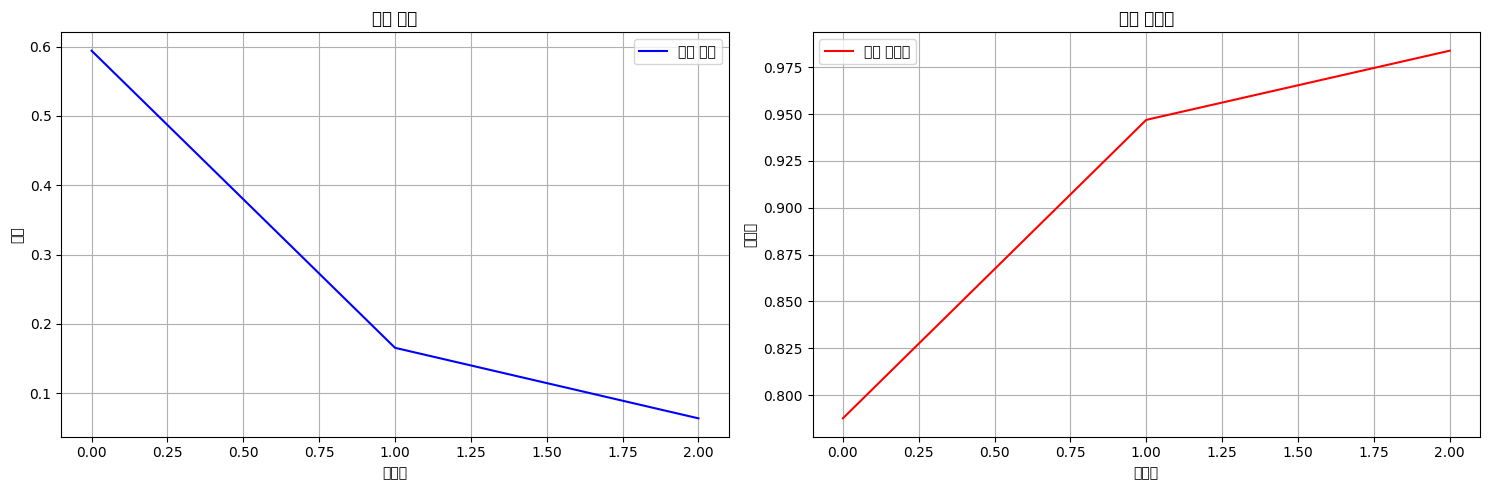

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44040 (\N{HANGUL SYLLABLE GAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52712 (\N{HANGUL SYLLABLE CWI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/l

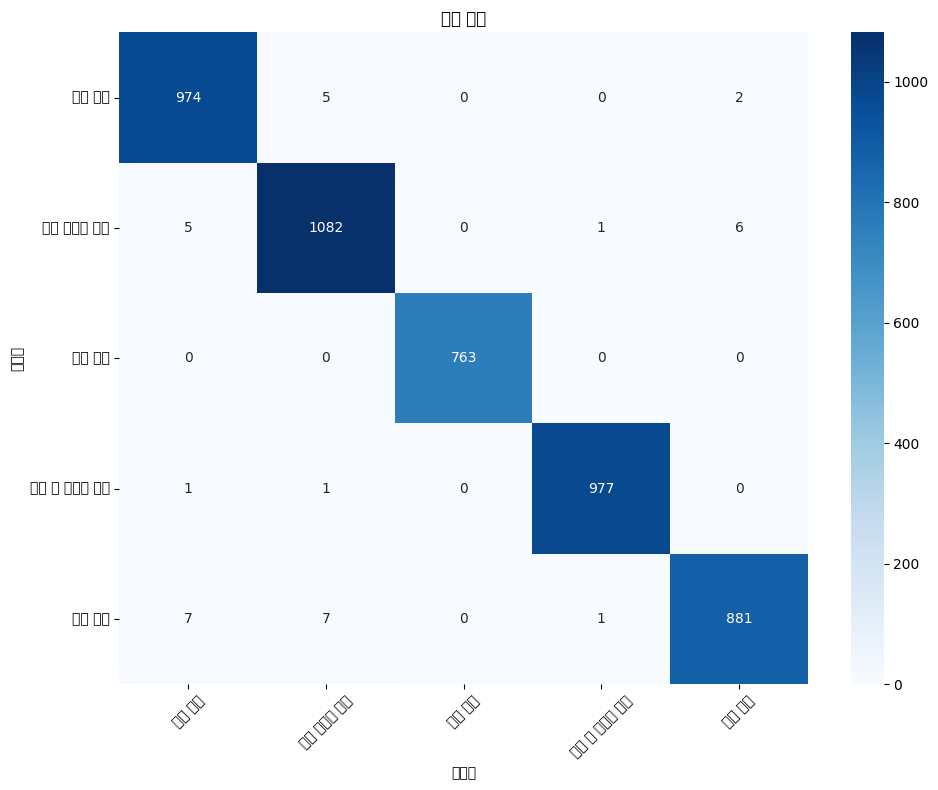


예측 테스트:
텍스트: '죽여버리겠어'
예측: 협박 대화 (신뢰도: 0.9964)

텍스트: '돈 빌려줘'
예측: 갈취 대화 (신뢰도: 0.9941)

텍스트: '오늘 날씨 정말 좋네요'
예측: 일반 대화 (신뢰도: 0.9985)

텍스트: '회사에서 괴롭힘 당하고 있어'
예측: 일반 대화 (신뢰도: 0.5560)



In [32]:
trainer, processed_data = main_training()